# Matplotlib
Matplotlib is the most widely used scientific plotting package in Python. Import it by typing <font color='blue'>import matplotlib  </font> in your notebook. Use help to learn about the contents of a library module. You can import specific items from a library module to shorten programs. One can use <font color='blue'>from ... import ...   </font> to load only specific items from a library module. Then refer to them directly without
library name as prefix.
You can create an alias for a library module when importing it to shorten programs. One can use <font color='blue'>import ... as ...</font> to create an alias. Create alias plt for library module pyplot in your
notebook.<br>

In [30]:
#import numpy as np
#import matplotlib.pyplot as plt

#this gives us access to numpy as np, and matplotlib.pyplot as plt
%pylab inline


Populating the interactive namespace from numpy and matplotlib


# how to plot an astronomical image and how to detect object in the image

<br> Let's import the packages we will use today: **[sep](https://sep.readthedocs.io/en/v1.1.x/)**, **[astropy](https://docs.astropy.org/en/stable/index.html)**  
<br> from **astropy** we will import: **fits** and **wcs**

In [31]:
from astropy.io import fits
from astropy import wcs as wcs
import sep

# read an image
**16335757.fits** is our test image. we will use fits.open to open and put the image in a variable hdu_list
<br> let's see the image format. Fits mean "Flexible Image Transport System" 
<br> this is a specific format composed by a metadata part and a data part.
The metadata (**header**) include all the info about the image and the data part is usually a bidimensional array. A fits image can have multiple layers of metadata and data, and each layer is called a **header and data unit (HDU)**.
<br> For example:<br>
<br> header, data  (level[0])
<br> header, data  (level[1])
<br> header, data  (level[2])

In [32]:
hdu_list = fits.open('16335757.fits')

<br> You can see how many layers your image has using the function len()

**<font color='blue'>Check how many layers the image has:</font>**

In [33]:
len(hdu_list)

1

Since the size is one, let's take a look at the layer zero. Each fits file has several important informations in what is called the header of the file. In the header you can find information like: the exposure time, the telescope, the data of the observations, the size of the date, the observer and sometimes also the informations of the part of the sky we observed 

In [34]:
header = hdu_list[0].header
header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 1024 / length of data axis 1                          
NAXIS2  =                 1024 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE-OBS= '2016-04-30T01:18:07' /YYYY-MM-DDThh:mm:ss observation start, UT      
EXPTIME =   60.000000000000000 /Exposure time in seconds                        
EXPOSURE=   60.000000000000000 /Exposure time in seconds                        
SET-TEMP=  -20.000000000000000 /CCD temperature setpoint in C                   
CCD-TEMP=  -20.1702352500000

**<font color='blue'>Exercise: </font>** Find **object name**, **RA** and **DEC** from the header

Now let see the data

In [35]:
img = hdu_list[0].data
print(img)

[[227.64964 242.42308 254.67735 ... 260.97653 234.49554 257.19666]
 [222.01602 265.02048 248.61688 ... 249.39539 249.02998 263.34747]
 [242.40106 235.84102 219.14624 ... 260.77954 227.6311  245.4189 ]
 ...
 [258.41376 235.47336 252.11043 ... 254.78888 252.02977 224.48628]
 [253.63196 250.44969 258.99002 ... 264.21622 246.82892 265.422  ]
 [243.02887 276.27774 218.37288 ... 207.54837 259.7037  248.36153]]


The data is an array, so we can actually use matplotlib to "imshow" the image

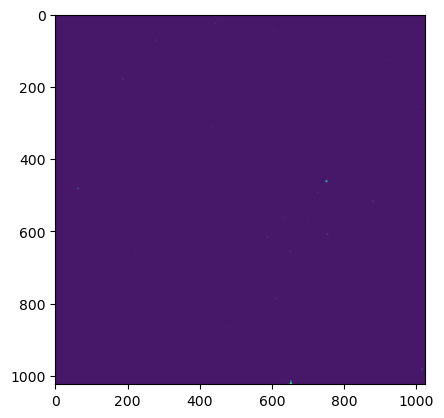

In [36]:
plt.imshow(img)

What is going on here? We do not see anything. Probably becasue there are some pixel in the array that have very low or very high counts.
So we can do a histogram and see the distribution of the points in the array 

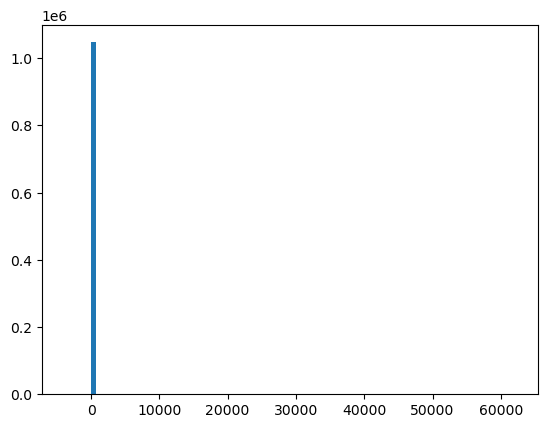

In [37]:
image_hist = plt.hist(img.flatten(), bins=100)

**<font color='blue'>Exercise: </font>**let's try to constrain the range of the histogram using range=(min_value, max_value). You can try different ranges until you find a range that can properly display the value distribution.

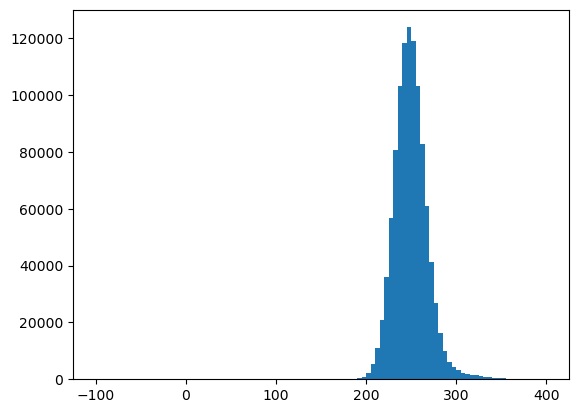

In [38]:
min_value = -100
max_value = 400
image_hist = plt.hist(img.flatten(), bins=100, range=(min_value, max_value))

let's now do the plot again using some limits. 
For **imshow**, we can use the keywords **vmin** and **vmax** to set limits on the color scaling.

what do yo think we should use?  (vmin=??, vmax=??)

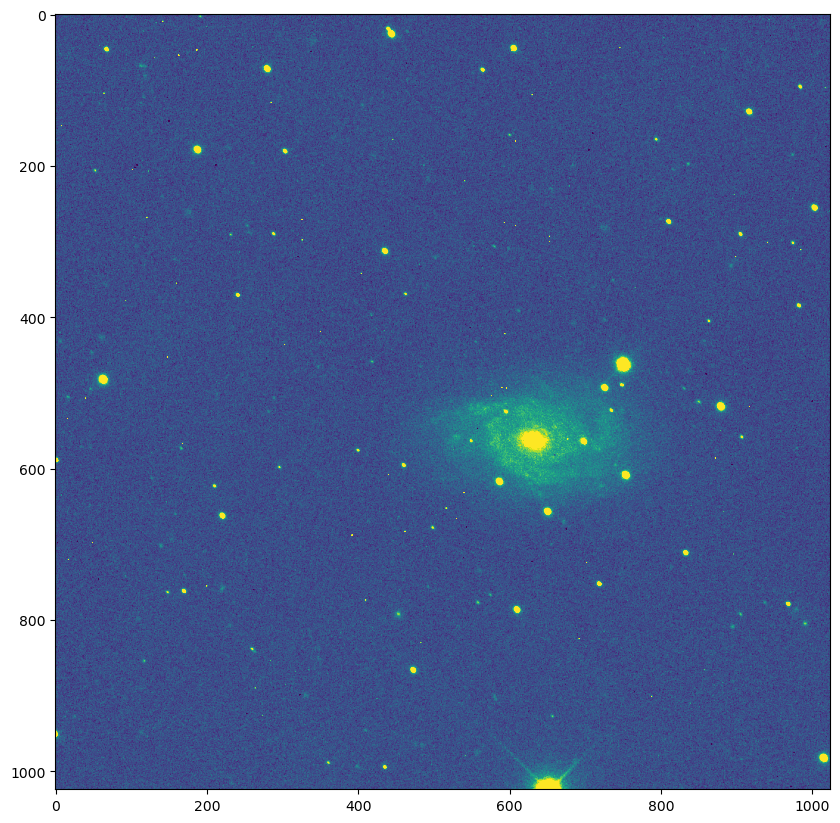

In [39]:
plt.figure(figsize=(10,12))
imgshow = plt.imshow(img, vmin=200, vmax=400)

We can choose another color map for display purpose (see more colormpas here: [colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html))

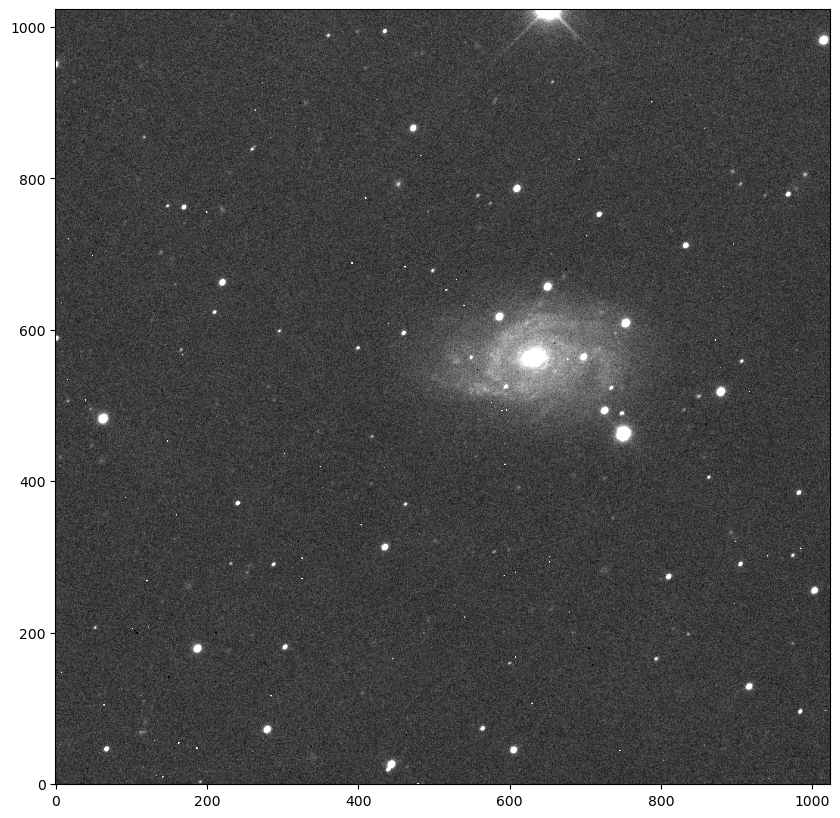

In [40]:
plt.figure(figsize=(10,12))
imgshow = plt.imshow(img, cmap='gray', origin='lower', vmin=200, vmax=400)

Now we would like to be able to find the position of all stars in the image. But in order to do that with the package [sep](https://sep.readthedocs.io/en/v1.1.x/), we need to define the background of the image. Sep has a command for that: sep.Background(X). 
But before doing that there is a command to run: X = X.byteswap().newbyteorder() (see [link1](https://sep.readthedocs.io/en/v1.1.x/tutorial.html#Finally-a-brief-word-on-byte-order) and [link2](https://github.com/kbarbary/sep/issues/23#issuecomment-155050901) if you want to know more about it)

In [41]:
img = img.byteswap().newbyteorder() # magic command
bkg = sep.Background(img)

Let's see what will happen if we subtract the background from the image

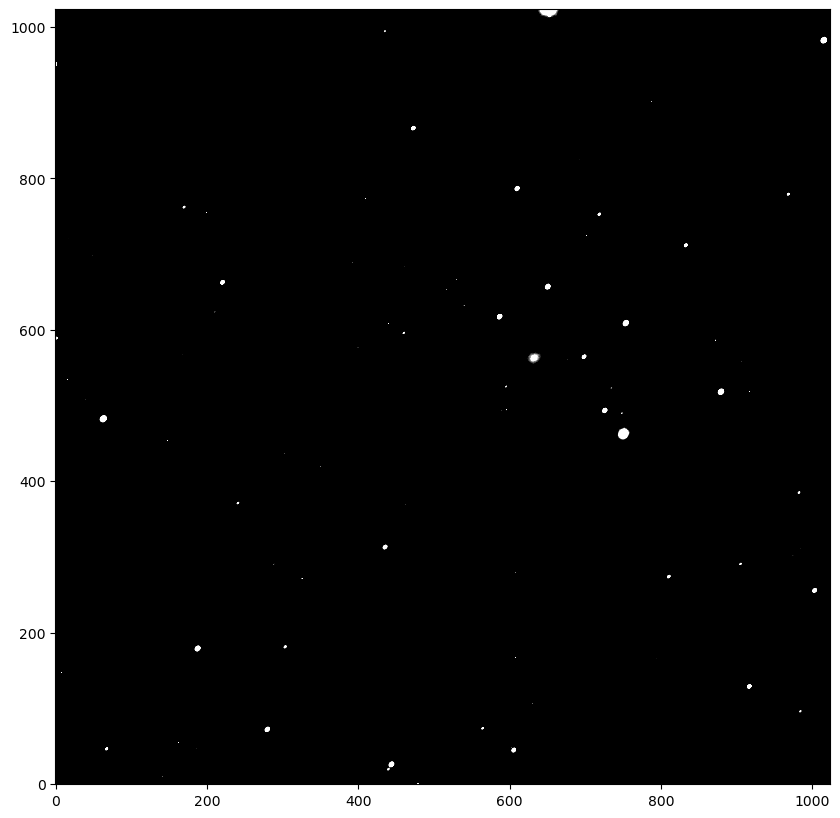

In [42]:
bkg_image = bkg.back()
img_sub = img - bkg
plt.figure(figsize=(10,12))
imgshow = plt.imshow(img_sub, cmap='gray', origin='lower', vmin=200, vmax=400)

Now we can extract all the objects from the image using the sep commmand sep.extract
and then we can plot all the star detected on our image.  thresh=20.0 define how many star we want to find. larger numbers means we find less objects. This is similar to a dictionary with each column that can be identified by a name. 

In [43]:
#objects = sep.extract(X, thresh=20.0, err=bkg.globalrms, mask=None, minarea=10, clean=True, clean_param=1.0, segmentation_map=False)
objects = sep.extract(img, thresh=20.0, err=bkg.globalrms, minarea=10)

**<font color='blue'>Exercise: </font>** Check the length and data type of **objects**

In [44]:
print(len(objects))
print(type(objects))
objects.dtype.names

52
<class 'numpy.ndarray'>


('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

objects is a NumPy structured array with many fields.

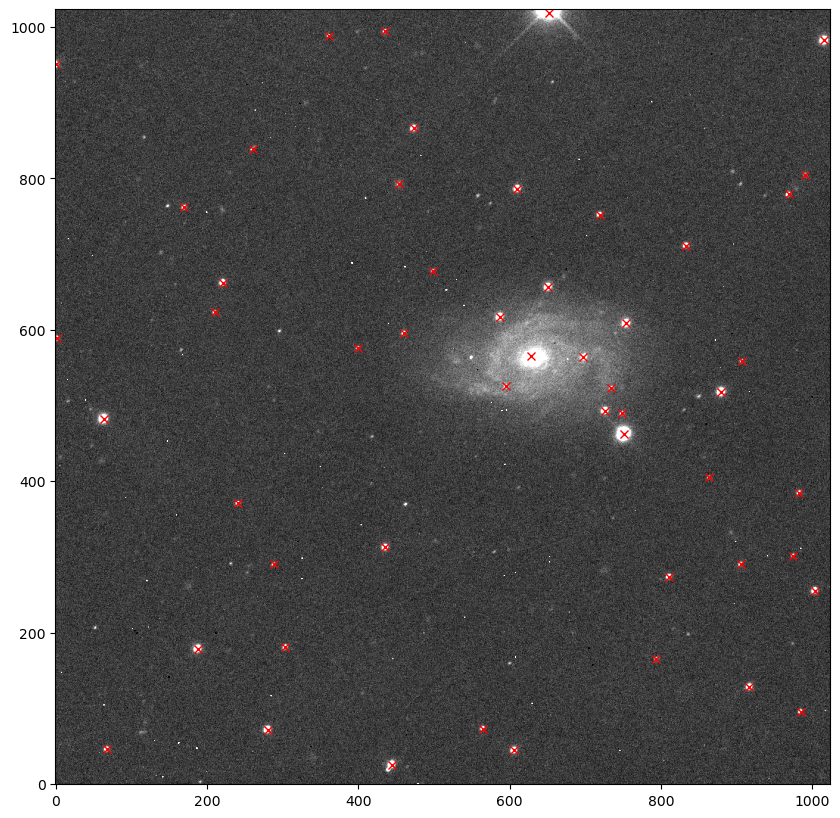

In [45]:
plt.figure(figsize=(10,12))
imgshow = plt.imshow(img, origin='lower', cmap='gray', vmin=200, vmax=400)
plt.plot(objects['x'],objects['y'],'xr')

### WCS

if we know the coordinate of one interesting object, how we find it in the image?
To do that we can use the information on the header of the file and convert the coordinate in pixel position. To do that we will use the [wcs](https://docs.astropy.org/en/stable/wcs/) package in astropy. 

In [46]:
#read the header
header = hdu_list[0].header
# import the wcs package
from astropy.wcs import WCS
# take information from the header about the coordinate where the image is pointing to.
w = WCS(header)
#transform coordinate in pixels:
Ra = 148.283666667
Dec = 16.7139583333
px, py = w.wcs_world2pix(Ra,Dec, 1)
print('my object should be close to these coordinate')
print(px,py)

my object should be close to these coordinate
611.6228472316652 786.023106657171


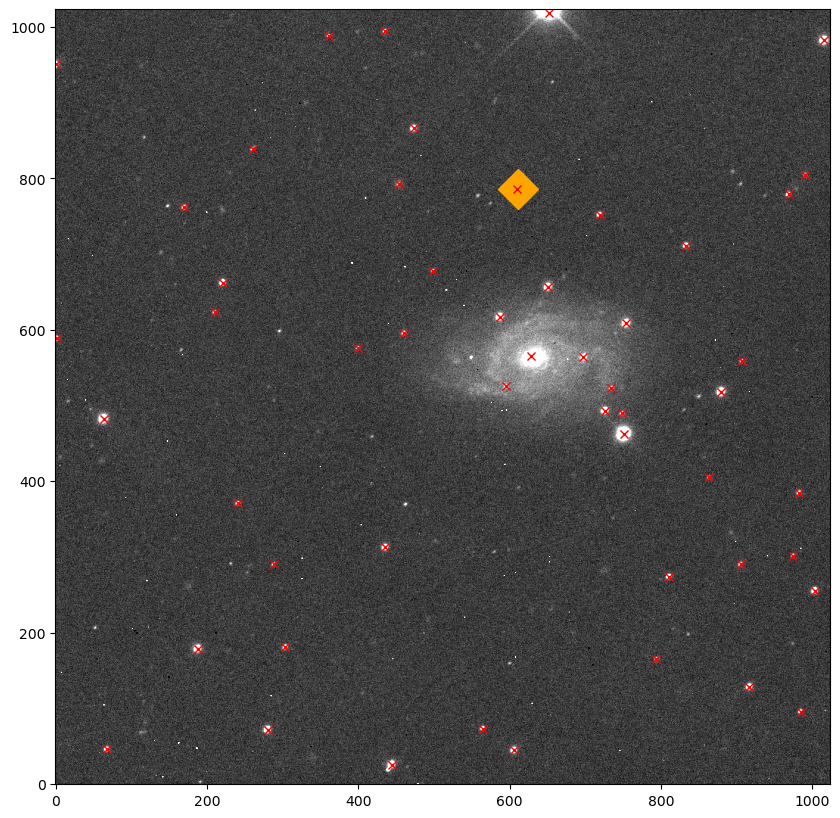

In [47]:
plt.figure(figsize=(10,12))
imgshow = plt.imshow(img, origin='lower', cmap='gray', vmin=200, vmax=400)
plt.plot(611,786,'D',color='orange',markersize=20)
plt.plot(objects['x'],objects['y'],'xr')

Now we want to identify in the object dictinary which is our object. We need to compare the pixel position for each object in the object dictionary with the pixel position we found. we need to measure the distance between them and take the object if the distance is less than XX pixels.
let's loop over the stars using enumerate and compute the difference between the coordinates

**enumerate** can give you a counting variable. It allows us to loop over something and have an automatic counter

In [48]:
values = ['a', 'b', 'c']
for value in values:
    print(value)

a
b
c


In [49]:
for value in enumerate(values):
    print(value)

(0, 'a')
(1, 'b')
(2, 'c')


In [50]:
for count, value in enumerate(values):
    print(count, value)

0 a
1 b
2 c


In [51]:
for i,j in enumerate(objects['x']):
    distance = np.sqrt((objects['x'][i]-px)**2+(objects['y'][i]-py)**2)
    print('distance ', distance)
    if distance < 10:
        print('FOUND', i)
        print('The coordinate is', objects['x'][i], objects['y'][i])
        break

distance  778.6005470163343
distance  918.4377214525197
distance  741.5085177861647
distance  714.4150348367656
distance  787.4898644860796
distance  784.7679373488967
distance  724.9768611048848
distance  647.3452294889049
distance  740.5879932301043
distance  679.2701780446961
distance  659.5254528291221
distance  549.6227140924582
distance  592.0127868708779
distance  576.2243516573914
distance  605.199997643066
distance  505.07364166899026
distance  556.5577483687035
distance  546.5243256263238
distance  456.74656941863003
distance  352.471923743342
distance  626.7303976658332
distance  326.6739341836758
distance  314.4467191006341
distance  379.0500456345646
distance  290.3753991419198
distance  261.421895843736
distance  372.93822077066704
distance  238.5449527637028
distance  298.3867005923684
distance  640.9051736147348
distance  243.2666197466133
distance  221.19377981738364
distance  227.34142737033721
distance  170.7276246374637
distance  433.19759849841216
distance  135.132

# Photometry and Flux
Now what we want to do with these objects? We probably want to measure how much light is emitted by each of them.

Let's zoom on one of them by cutting a small box of 40 x 40 pixels with one object in the center.Tto cut a region we should do  <font color='blue'> img[a:b,c:d] </font> with a,b,c,d the pixels (integer) at the edges of the small matrix. 

* let's do that for the element 10 of the object dictionary. `object['x'][10]` and `object['y'][10]`

* let's now plot the zoomed image!



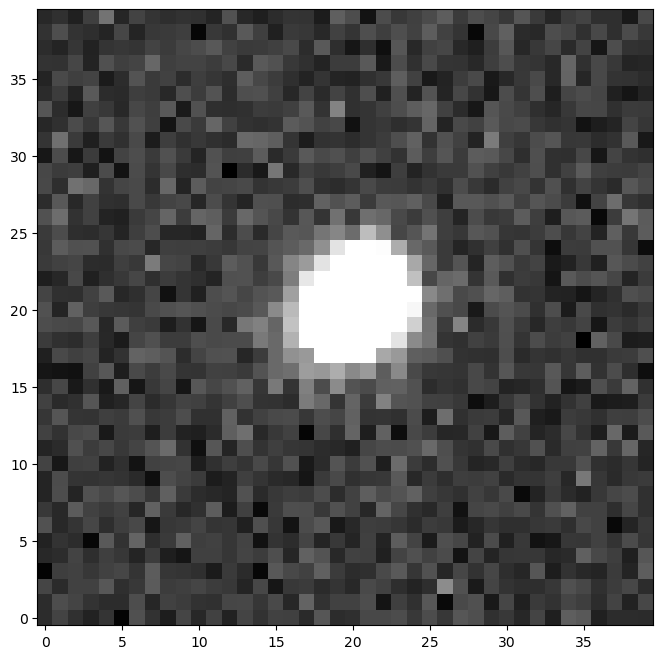

In [52]:
obj_10_y = int(objects['y'][10])
obj_10_x = int(objects['x'][10])

#The entire slice! -20 and + 20 all around this object from the image data
obj_10 = img[
    obj_10_y-20:obj_10_y+20,
    obj_10_x-20:obj_10_x+20
  ] 

fig, ax = plt.subplots(ncols=1, figsize=(8, 8))
imgshow = ax.imshow(obj_10, origin='lower', cmap='gray', vmin=200, vmax=400)

Here we used a diffrent way of making a figure. We made a figure and add some axes on it. This command is very good when you want to add more than one pannel in your figure.
More info here [subplot](https://matplotlib.org/tutorials/intermediate/artists.html)

### How do we define where the star `begins` or `ends`??

Let's do a test!

We want to see the amount of flux at a given radius going out from the center of the circle. I will define the `edge` of my star where the amount of flux stops growing.

* We can utilize the `sep.sum_circle()` function to find the amount of flux inside a given radius
* Below, we iterate radii from 1-20 pixels from the center of our star, and plot the flux.
* here we use the background-subtracted image: `img_sub`



Text(0, 0.5, 'flux (counts)')

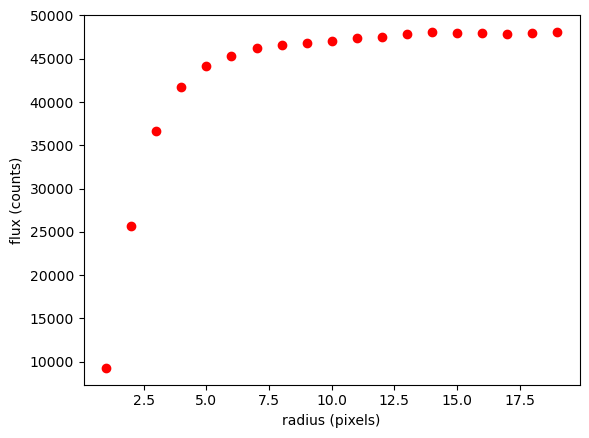

In [53]:
fluxvec = []
radiuscev = []
for radius in range(1,20):
    flux, fluxerr, flag = sep.sum_circle(img_sub, [objects['x'][10]], [objects['y'][10]],
                                         radius, err=bkg.globalrms, gain=1.0)
    fluxvec.append(flux)
    radiuscev.append(radius)

plt.plot(radiuscev,fluxvec,'or')
plt.xlabel('radius (pixels)')
plt.ylabel('flux (counts)')



Let's select the region to get all the counts of the object. We can use a circle.

<font color='blue'> From the plot above: How large should be the radius? </font>

EXERCISE:

* <font color='blue'> Lets plot 3 circles of different radii (8,10,12) around our object to get an idea where the flux is coming from.</font>

Hint:

* To plot a circle you will first need to define a matplotlib `Circle` object and then add it to your ax patches like so:

```
c1 = Circle((x,y),radius, color='r', lw=4, fill=False)
ax.add_patch(c1)
```

* here (x,y) will be the center of our star (20, 20)
* lw - stands for linewidth, let's leave it at 4 pixels wide
* fill=False, we leave this at false. If true, it will plot an full colored circle, not just a ring.

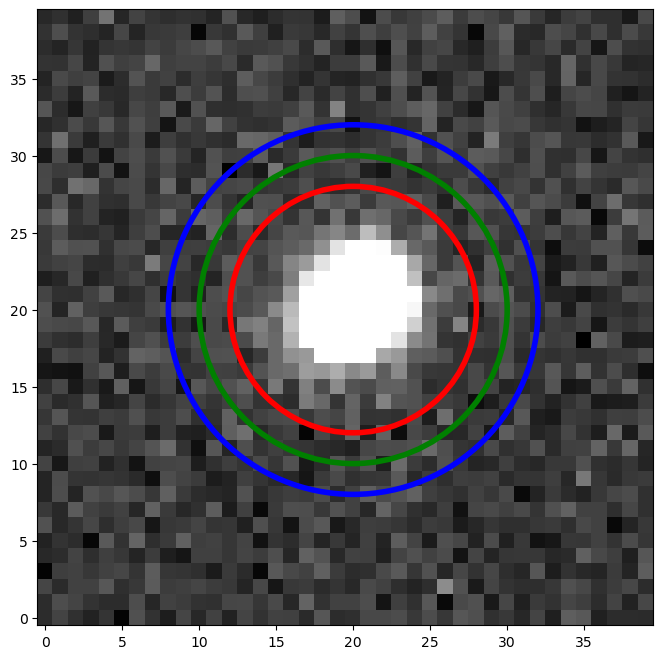

In [54]:
fig, ax = plt.subplots(ncols=1, figsize=(8, 8))
imgshow = ax.imshow(obj_10, origin='lower', cmap='gray', vmin=200, vmax=400)
circ = Circle((20,20),8 ,color='r', lw=4, fill=False)
ring1 = Circle((20,20),10 ,color='g',lw=4, fill=False)
ring2 = Circle((20,20),12 ,color='b',lw=4, fill=False)
ax.add_patch(circ)
ax.add_patch(ring1)
ax.add_patch(ring2)



### Now that we have defined the "Edge" of our star, Lets get its flux!

EXERCISE: <font color='blue'>Measuring Flux of our object</font>
* using the sep.sum_circle() method from above obtain the flux and error from our 10th element object
* `flux, fluxerr, flag = sep.sum_circle(img_sub, [x], [y], radius, err=bkg.globalrms, gain=1.0)`



In [55]:
flux, fluxerr, flag = sep.sum_circle(img_sub, [objects['x'][10]], [objects['y'][10]],
                                         10, err=bkg.globalrms, gain=1.0)

print(flux)



[47091.98190247]


### To clarify:

* What we have just measured is the number of counts within a radius of ?? pixel(s) for one object we selected in the image. 
* How do we use this measurement in astronomy? We usually convert this measurment into a magnitude, and if we know how our telescope is performing, then we know how bright a star appears to be. How bright actually is (absolute magnitude) depends on how far the star is. 

### Magnitudes!
* <font color='blue'> Let's first convert the flux into an instrumental magnitude. </font> 
* The equation we will use is `inst_mag = -2.5*np.log10(flux)`
* print it out!


In [57]:
inst_mag = -2.5 *np.log10(flux[0])
print('instrumental magnitude ', inst_mag)

instrumental magnitude  -11.682367421115941


### We are not done yet...

* We still need to transform this 'instrumental magnitude' into a calibrated apparent magnitude. This value will actually mean something astronomically, in comparison with a standardized magnitude system. 

* In order to do this primary calibration, we need to know the apparent magnitude of at least one object in the field... a <b>standard star</b>! 

* We need to measure its instrumental magnitude and subtract it from its known apparent magnitude and obtain what we call the "<b>zeropoint</b>".

* Once we have the zeropoint, we can measure the magnitudes of any object in the image by adding it to the instrumental magnitude!

EXERCISE: <font color='blue'> Measuring the zeropoint. </font>

* <font color='blue'> I know the apparent magnitude of the 9th element of our objects is 15, using the code above calculate the zeropoint for our image </font>

HINTS:

* Copy the code above and calculate inst_mag using the sep.sum_circle() function on the 9th element of our objects list, you can keep the radius at 10.
* `zeropoint = app_mag - inst_mag; (app_mag = 15)`
    

In [58]:
# instrumental magnitude for object[9]
flux9, fluxerr9, flag9 = sep.sum_circle(img_sub, [objects['x'][9]], [objects['y'][9]],
                                         10, err=bkg.globalrms, gain=1.0)
inst_mag9 = -2.5 *np.log10(flux9[0])
app_mag9 = 15 
zero_point = app_mag9 - inst_mag9
print('the zeropoint of the image is', zero_point)

the zeropoint of the image is 25.38090805363596


### The final goal! 

* <font color='blue'> Now that you know the zeropoint of the image, calculate the apparent magnitude of our star of interest! </font>

HINT:

* `app_mag = zeropoint + inst_mag`


In [59]:
app_mag10 = inst_mag + zero_point
print(app_mag10)


13.698540632520018


# Distance modulus

* We have learned that knowing the apparent and absolute magnitudes can give us a distance to the source (Distance Modulus).

* `distance_modulus = apparent_mag - absolute_mag`

* <font color='blue'>What if we already knew the distance modulus to a star in our image above? What information could we get from what we learned today? </font>

* Knowning the absolute magnitude of an object is important for initial supernova discoveries. For example, this can can give us a guess of its type before we even have a spectrum.

* <font color='blue'> If we knew the distance modulus to our image as: `30 mag`. What would be the absolute magnitude of our star? </font>


In [61]:
abs_mag = app_mag10 - 30
print(abs_mag)

-16.301459367479982
